In [1]:
import sys
print(sys.executable)

/home/javitrucas/miniconda3/envs/tfg/bin/python


In [2]:
import sys
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# Importaciones necesarias
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

# Agregar la ruta de los scripts al sistema
import sys
sys.path.append(os.path.abspath("../scripts"))

# Importar el modelo y las clases de datasets
from scripts.model import MILModel
from data.datasets.SCStandardMILDataset import SCStandardMILDataset
from data.datasets.MCStandardMILDataset import MCStandardMILDataset
from data.datasets.FalseFrequencyMILDataset import FalseFrequencyMILDataset

/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
# Configuración general
DATA_DIR = "../data/datasets"  # Carpeta donde están los datasets
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
FEATURE_DIM = 128
POOLING_TYPE = "attention"  # Opciones: 'attention', 'mean', 'max'

# Parámetros específicos de los datasets
D = 10  # Dimensionalidad de los datos
NUM_BAGS = 100  # Número de bolsas
B = 5  # Número de instancias negativas por bolsa
POS_CLASS_PROB = 0.5  # Probabilidad de que una bolsa sea positiva
SEED = 42  # Semilla para reproducibilidad

In [5]:
# Crear instancias de los datasets
sc_dataset = SCStandardMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=POS_CLASS_PROB,
    train=True,
    seed=SEED
)

mc_dataset = MCStandardMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=POS_CLASS_PROB,
    train=True,
    seed=SEED
)

false_freq_dataset = FalseFrequencyMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=POS_CLASS_PROB,
    train=True,
    seed=SEED
)

# Crear dataloaders
sc_loader = DataLoader(sc_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=sc_dataset.collate_fn)
mc_loader = DataLoader(mc_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=mc_dataset.collate_fn)
false_freq_loader = DataLoader(false_freq_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=false_freq_dataset.collate_fn)

=== SCStandard Dataset ===
Bag Label: tensor(0)
Instance Labels: tensor([-1.,  0.,  0.,  0.,  0.,  0., -2., -2.])


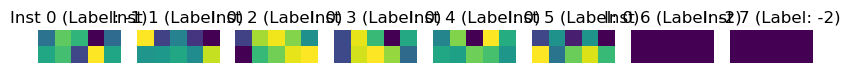

=== MCStandard Dataset ===
Bag Label: tensor(1)
Instance Labels: tensor([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2., -2.])


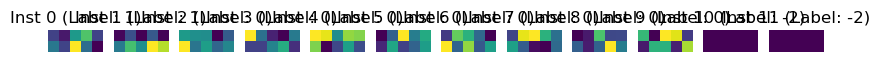

=== False Frequency Dataset ===
Bag Label: tensor(0)
Instance Labels: tensor([ 0.,  0.,  0.,  0.,  0., -1., -2., -2., -2., -2.])


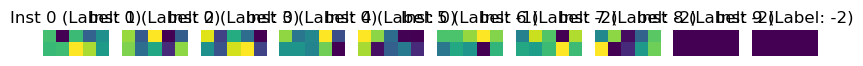

In [6]:
def visualize_bag(bag_data, bag_label, instance_labels):
    """
    Visualiza una bolsa de instancias junto con sus etiquetas.
    """
    print("Bag Label:", bag_label)
    print("Instance Labels:", instance_labels)
    plt.figure(figsize=(10, 5))
    for i, instance in enumerate(bag_data):
        plt.subplot(1, len(bag_data), i + 1)
        plt.title(f"Inst {i} (Label: {instance_labels[i].item():.0f})")
        plt.imshow(instance.numpy().reshape(2, -1), cmap="viridis")
        plt.axis("off")
    plt.show()

# Visualizar un ejemplo de cada dataset
print("=== SCStandard Dataset ===")
for bag_data, bag_label, instance_labels, adj_mat, mask in sc_loader:
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

print("=== MCStandard Dataset ===")
for bag_data, bag_label, instance_labels, adj_mat, mask in mc_loader:
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

print("=== False Frequency Dataset ===")
for bag_data, bag_label, instance_labels, adj_mat, mask in false_freq_loader:
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

In [7]:
# Configuración para SCStandard
D = 10  # ¡Ajusta esto según el dataset!
FEATURE_DIM = 64  # Ejemplo: reduce a 64 para SCStandard
POOLING_TYPE = "attention"

# Instanciar el modelo con las dimensiones correctas
model = MILModel(
    input_feature_dim=D,  # Usa D=10 para SCStandard
    feature_dim=FEATURE_DIM,
    pooling_type=POOLING_TYPE,
    dropout_prob=0.5
).to(DEVICE)

# Función de pérdida y optimizador
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [8]:
def train_model(loader, model, criterion, optimizer, epochs=NUM_EPOCHS):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for bag_data, bag_label, instance_labels, adj_mat, mask in loader:
            bag_data, bag_label = bag_data.to(DEVICE), bag_label.float().to(DEVICE)
            mask = mask.to(DEVICE) if mask is not None else None

            optimizer.zero_grad()
            predictions, _ = model(bag_data, mask=mask)
            loss = criterion(predictions.squeeze(), bag_label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Entrenar el modelo en el SCStandard Dataset
print("=== Entrenando en SCStandard Dataset ===")
train_model(sc_loader, model, criterion, optimizer)

=== Entrenando en SCStandard Dataset ===
Epoch 1/10, Loss: 12.1310
Epoch 2/10, Loss: 7.8443
Epoch 3/10, Loss: 5.8607
Epoch 4/10, Loss: 4.0739
Epoch 5/10, Loss: 3.7978
Epoch 6/10, Loss: 2.9215
Epoch 7/10, Loss: 2.0318
Epoch 8/10, Loss: 1.3755
Epoch 9/10, Loss: 1.1077
Epoch 10/10, Loss: 0.7819


In [9]:
def evaluate_model(loader, model):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for bag_data, bag_label, _, _, mask in loader:
            bag_data = bag_data.to(DEVICE)
            mask = mask.to(DEVICE) if mask is not None else None
            output, _ = model(bag_data, mask=mask)
            preds = (torch.sigmoid(output) > 0.5).float().squeeze().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(bag_label.cpu().numpy())
    
    # Calcular métricas
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Accuracy: {accuracy:.4f}, AUC: {auc:.4f}, F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

# Evaluar el modelo en el SCStandard Dataset
print("=== Evaluando en SCStandard Dataset ===")
evaluate_model(sc_loader, model)

=== Evaluando en SCStandard Dataset ===
Accuracy: 1.0000, AUC: 1.0000, F1-Score: 1.0000
Confusion Matrix:
[[50  0]
 [ 0 50]]


In [10]:
# Crear el dataset
dataset = MCStandardMILDataset(D=2, num_bags=10, B=3)

# Crear el DataLoader con el collate_fn corregido
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=dataset.collate_fn
)

# Probar un batch
for bag_data, bag_label, inst_labels, adj_mat, mask in loader:
    print("Bag Data Shape:", bag_data.shape)
    print("Instance Labels Shape:", inst_labels.shape)
    print("Mask Shape:", mask.shape)
    print("Adjacency Matrix Shape:", adj_mat.shape)
    break

Bag Data Shape: torch.Size([4, 11, 2])
Instance Labels Shape: torch.Size([4, 11])
Mask Shape: torch.Size([4, 11])
Adjacency Matrix Shape: torch.Size([4, 11, 11])


In [11]:
# Repetir el proceso para otros datasets
print("=== Entrenando en MCStandard Dataset ===")
train_model(mc_loader, model, criterion, optimizer)

print("=== Evaluando en MCStandard Dataset ===")
evaluate_model(mc_loader, model)

print("=== Entrenando en False Frequency Dataset ===")
train_model(false_freq_loader, model, criterion, optimizer)

print("=== Evaluando en False Frequency Dataset ===")
evaluate_model(false_freq_loader, model)

=== Entrenando en MCStandard Dataset ===
Epoch 1/10, Loss: 0.5712


Epoch 2/10, Loss: 0.4434
Epoch 3/10, Loss: 0.1079
Epoch 4/10, Loss: 0.0827
Epoch 5/10, Loss: 0.1313
Epoch 6/10, Loss: 0.0743
Epoch 7/10, Loss: 0.0657
Epoch 8/10, Loss: 0.0362
Epoch 9/10, Loss: 0.0331
Epoch 10/10, Loss: 0.0623
=== Evaluando en MCStandard Dataset ===
Accuracy: 1.0000, AUC: 1.0000, F1-Score: 1.0000
Confusion Matrix:
[[50  0]
 [ 0 50]]
=== Entrenando en False Frequency Dataset ===


RuntimeError: The size of tensor a (6) must match the size of tensor b (7) at non-singleton dimension 1